In [5]:
%pylab notebook
import sympy as sp
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

Populating the interactive namespace from numpy and matplotlib


In [6]:
pathout = "../figures/" + "reproduce_jenss_results/"
! mkdir $pathout

mkdir: ../figures/reproduce_jenss_results/: File exists


In [7]:
h=6.62607004e-34 #Plancks constant #m2 kg / s
k=1.38064852e-23 #Boltzmann constant #m2 kg s-2 K-1

def mbb(nu,T,A,alpha,nu0=1.):
    x=h*nu*1e9/(k*T)
    Inu=A*((nu/nu0)**alpha)*(nu**3.)/(exp(x)-1.)
    return Inu

def multitemp_mbb_spectra(nu,T1,A1,alpha1,T2,A2,alpha2,nu0=1.):
    Inu=mbb(nu,T1,A1,alpha1,nu0=nu0) + mbb(nu,T2,A2,alpha2,nu0=nu0)
    return Inu

# Moment expansion for a modified black body spectra

In [8]:
def y1(x):
    return x*exp(x)/(exp(x)-1.)

def y2(x):
    return y1(x)*x*cosh(0.5*x)/sinh(0.5*x)

def y3(x):
    return y1(x)*x*x*(cosh(x)+2)/(cosh(x)-1)

def y4(x):
    return y2(x)*0.5*x*x*(cosh(x)+5)/(sinh(0.5*x)**2.)

def y5(x):
    return y1(x)*(x**4.)*(33.+26*cosh(x)+cosh(2.*x))/(8.*sinh(0.5*x)**4.)

def f_mbb(nu,T,alpha,A,p22,p23,p33,p222,p223,p233,p333):
    x=h*nu*1e9/k/T
    nu0=k*T/h/1e9
    I0=A*(((nu/nu0)**alpha)*(nu**3.))/(exp(x)-1.)
    temp=I0*(1. + 0.5*p22*(log(nu/nu0))**2. + p23*log(nu/nu0)*y1(x)+ 0.5*p33*y2(x))
    temp = temp +  I0*(p222*(log(nu/nu0)**3.)/6. + 0.5*p223*(log(nu/nu0)**2.)*y1(x) + 0.5*p233*log(nu/nu0)*y2(x) + p333*y3(x)/6.)
    return temp

1.0 12.9898662496 270.664805898


<IPython.core.display.Javascript object>


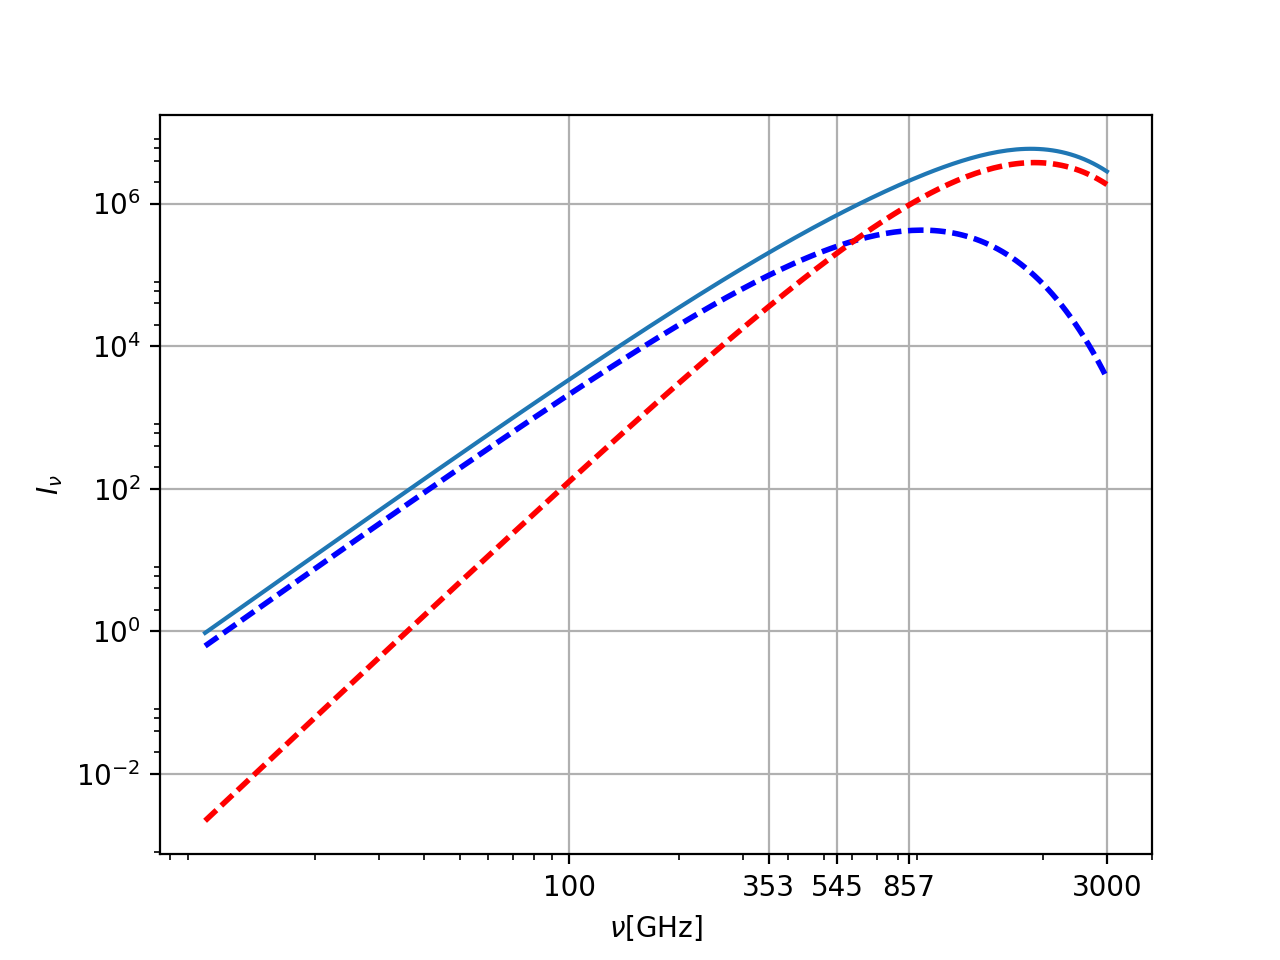

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [9]:
f=0.34188
T1=9.75 ; A1=f; alpha1=1.63; T2=15.7 ; A2 =(1.-f); alpha2=2.82

Abar=A1+A2
Tbar=Abar/((A1/T1)+(A2/T2))
nu0=k*Tbar/h/1e9
print Abar,Tbar,nu0

nu=logspace(log10(10),log10(3000),200)
Inu=multitemp_mbb_spectra(nu,T1,A1,alpha1,T2,A2,alpha2,nu0=3000.)


fn=interp1d(nu,Inu,kind="quadratic") ; norm=3388/fn(100.)
Inu=Inu*norm

figure()
plot(nu,Inu)
plot(nu,mbb(nu,T1,A1,alpha1,nu0=3000.),"b--",lw=2)
plot(nu,mbb(nu,T2,A2,alpha2,nu0=3000.),"r--",lw=2)
loglog()
ylabel(r"$I_{\nu}$")
xlabel(r"$\nu$[GHz]")
grid()
legend(loc=0)
xticks([100,353,545,857,3000],[100,353,545,857,3000])

savefig(pathout + "model_sed.pdf",dpi=150,bbox_inches="tight")
savefig(pathout + "model_sed.jpeg",dpi=150,bbox_inches="tight")

# Fitting the moments of the distribution

In [11]:
sl=-0.

p0=(30.,0.,1e-6)
lb0=(0., -3.,0.) ; ub0=(100,3.,10.)
fitp0, fitcov0=curve_fit(lambda x, T, alpha, A: f_mbb(x, T, alpha, A, p22=0., p23=0.,p33=0.,p222=0.,p223=0.,p233=0.,p333=0.), nu,Inu,p0,sigma=1e-5*Inu/(nu**sl),absolute_sigma=True,bounds=(lb0,ub0),maxfev=200000)
print fitp0

prange=2.
nu1=nu[nu>=300] ; Inu1=Inu[nu>=300]
p0=(5.,1.,1.,0.,0.,0.)
lb1=append(lb0,[-prange,-prange,-prange])
ub1=append(ub0,[prange,prange,prange])
fitp1, fitcov1=curve_fit(lambda x, T, alpha, A, p22, p23, p33: f_mbb(x, T, alpha, A, p22, p23,p33,p222=0.,p223=0.,p233=0.,p333=0.), nu1,Inu1,p0,sigma=1e-5*Inu1/(nu1**sl),absolute_sigma=True,bounds=[lb1,ub1],maxfev=200000)
print fitp1

#nu2=nu[nu<=2000] ; Inu2=Inu[nu<=2000]
nu2=nu ; Inu2=Inu
#p0=append(fitp1,(0.,0.,0.,0.))
p0=(5.,1.,1.,0.,0.,0.,0.,0.,0.,0.)
#prange=100.
lb2=append(lb1,[-prange,-prange,-prange,-prange])
ub2=append(ub1,[prange,prange,prange,prange])
fitp2, fitcov2=curve_fit(lambda x, T, alpha, A, p22, p23, p33, p222,p223,p233,p333: f_mbb(x, T, alpha, A, p22, p23,p33,p222,p223,p233,p333), nu2,Inu2,p0,sigma=1e-5*Inu2/(nu2**sl),absolute_sigma=True,bounds=[lb2,ub2],maxfev=200000)
print fitp2

[  1.94129075e+01   1.55633134e+00   7.98695474e-03]
[  1.51617458e+01   1.32515060e+00   5.92552334e-03  -3.85436972e-01
   1.33214101e-01   1.99216042e-01]
[  1.55288905e+01   7.04446312e-01   3.24359615e-03   1.99999929e+00
  -1.47627605e-01   1.05524227e+00   4.54607196e-02  -1.74607877e+00
   9.42761570e-01  -2.06979431e-01]


<IPython.core.display.Javascript object>


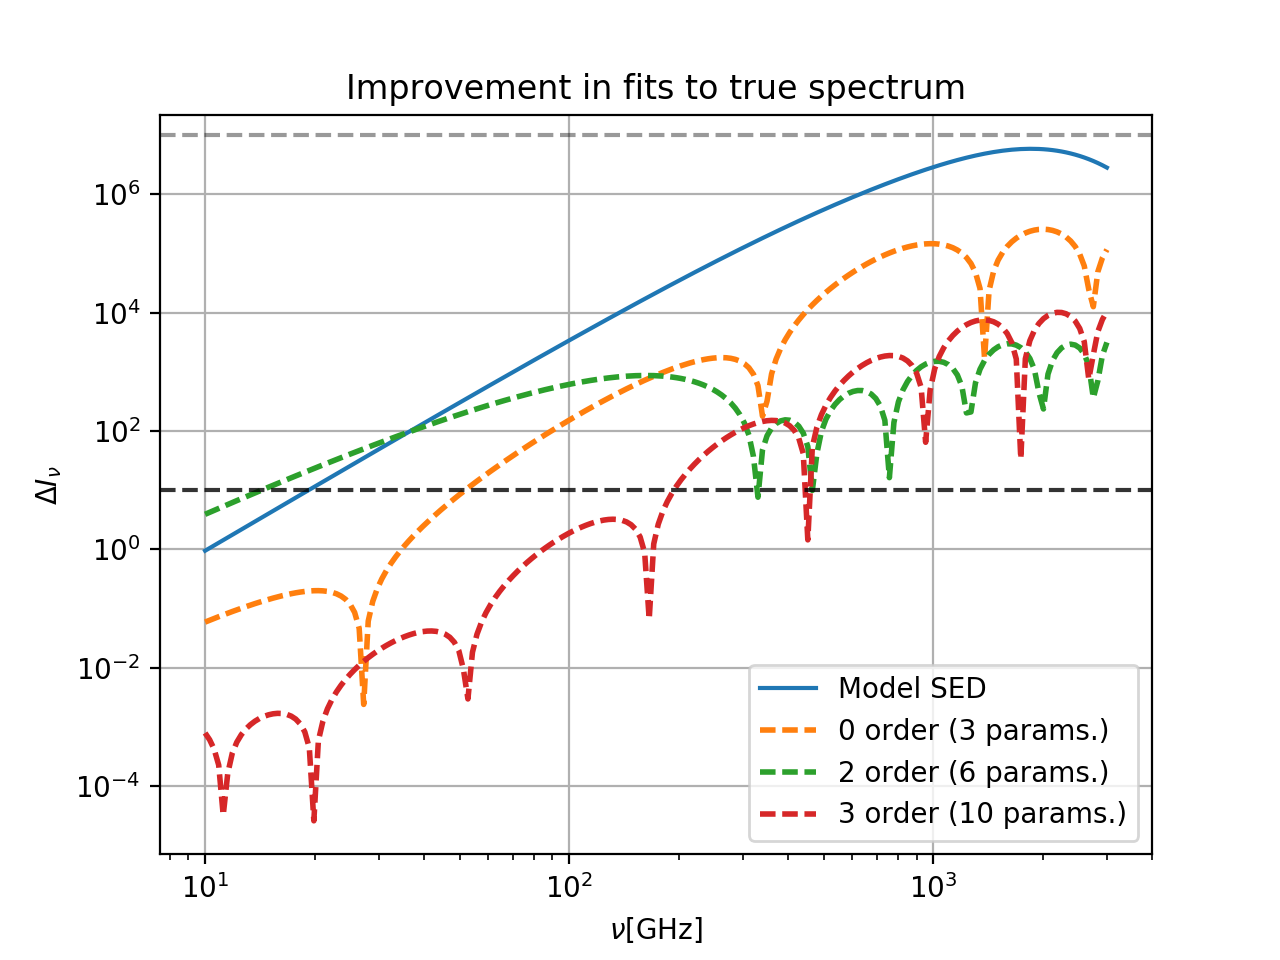

<IPython.core.display.Javascript object>


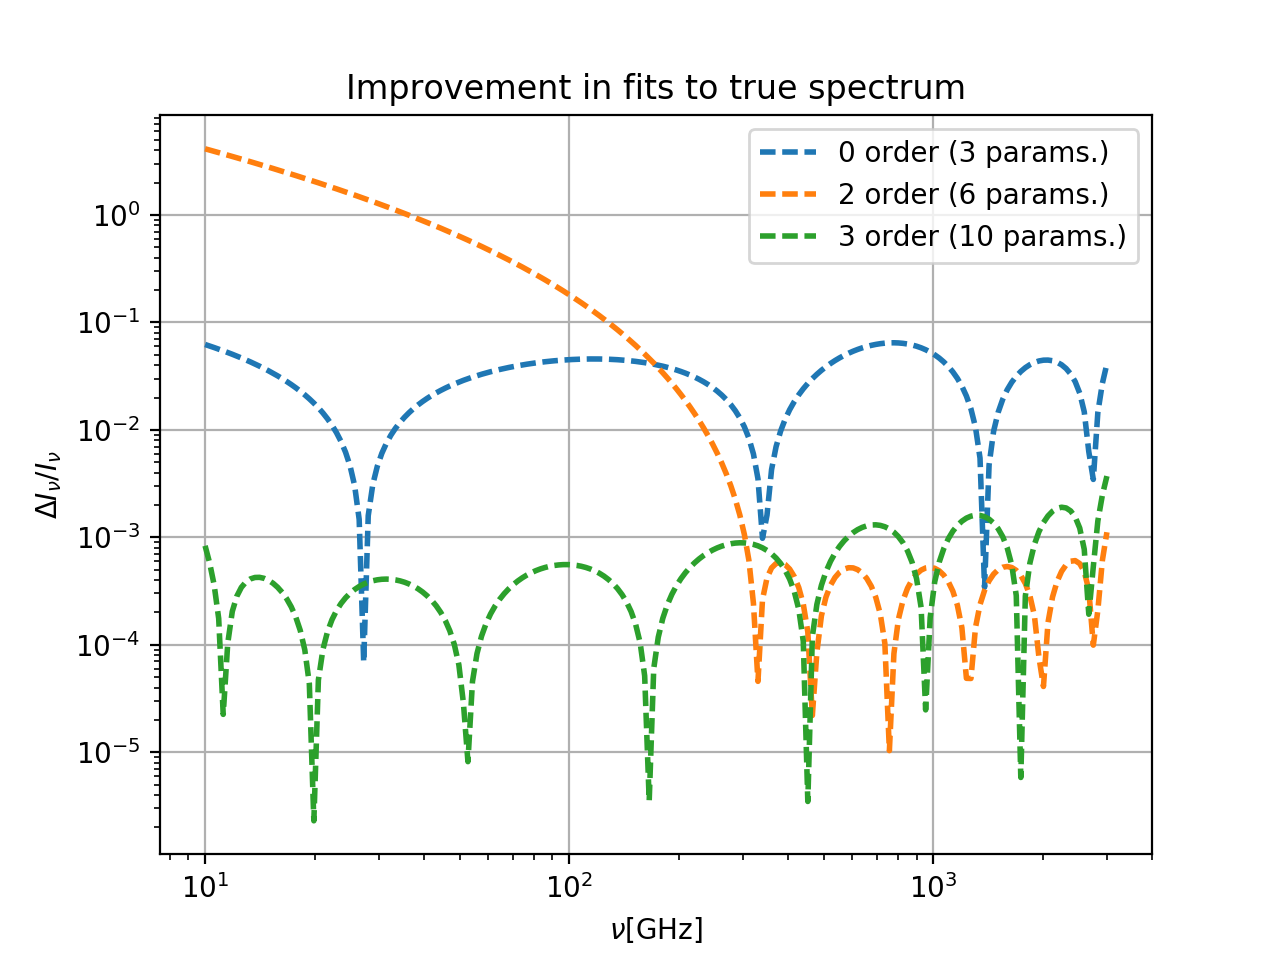

<IPython.core.display.Javascript object>


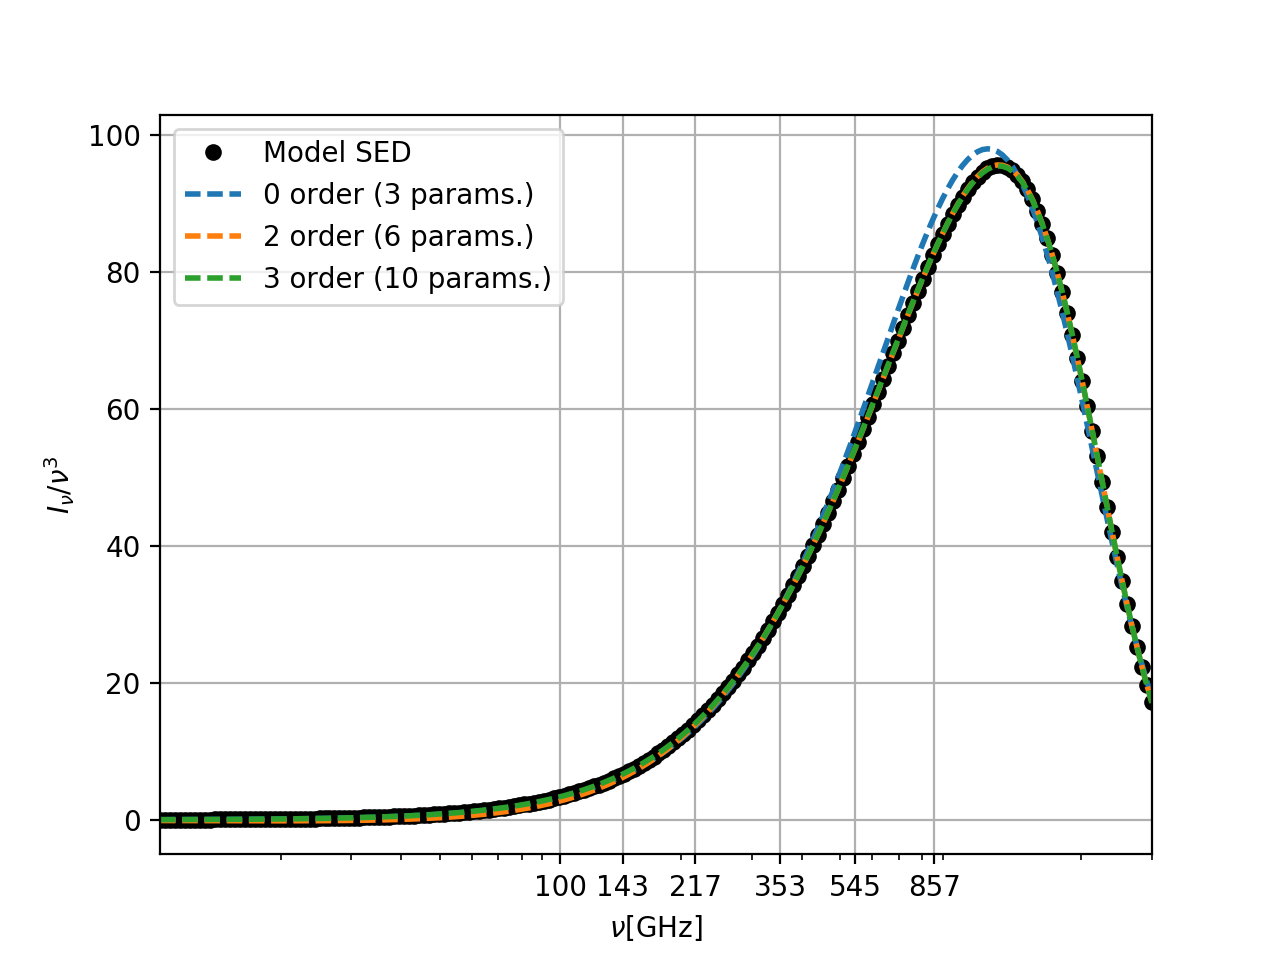

In [12]:
figure()
title("Improvement in fits to true spectrum")
pllabel="Model SED"
plot(nu,Inu,label=pllabel)
pllabel="0 order (3 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp0[0],alpha=fitp0[1], A=fitp0[2],p22=0., p23=0.,p33=0.,p222=0.,p223=0.,p233=0.,p333=0.)),"--",lw=2,label=pllabel)
pllabel="2 order (6 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp1[0],alpha=fitp1[1], A=fitp1[2],p22=fitp1[3], p23=fitp1[4],p33=fitp1[5],p222=0.,p223=0.,p233=0.,p333=0.)),"--",lw=2,label=pllabel)
pllabel="3 order (10 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp2[0],alpha=fitp2[1], A=fitp2[2],p22=fitp2[3], p23=fitp2[4],p33=fitp2[5],p222=fitp2[6],p223=fitp2[7],p233=fitp2[8],p333=fitp2[9])),"--",lw=2,label=pllabel)
semilogy()
loglog()
ylabel(r"$\Delta I_{\nu}$")
xlabel(r"$\nu$[GHz]")
#xticks([100,300,600,1000,3000],[100,300,600,1000,3000])
grid()
axhline(1e1,color="black",linestyle="dashed",alpha=0.8)
axhline(1e7,color="black",linestyle="dashed",alpha=0.4)
legend(loc=0)
#ylim(1e-1,1e7)
#xlim(1,3000)
savefig(pathout + "/reproduce_fig6.pdf",dpi=150,bbox_inches="tight")
savefig(pathout + "/reproduce_fig6.jpeg",dpi=150,bbox_inches="tight")


figure()
title("Improvement in fits to true spectrum")
pllabel="0 order (3 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp0[0],alpha=fitp0[1], A=fitp0[2],p22=0., p23=0.,p33=0.,p222=0.,p223=0.,p233=0.,p333=0.))/Inu,"--",lw=2,label=pllabel)
pllabel="2 order (6 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp1[0],alpha=fitp1[1], A=fitp1[2],p22=fitp1[3], p23=fitp1[4],p33=fitp1[5],p222=0.,p223=0.,p233=0.,p333=0.))/Inu,"--",lw=2,label=pllabel)
pllabel="3 order (10 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp2[0],alpha=fitp2[1], A=fitp2[2],p22=fitp2[3], p23=fitp2[4],p33=fitp2[5],p222=fitp2[6],p223=fitp2[7],p233=fitp2[8],p333=fitp2[9]))/Inu,"--",lw=2,label=pllabel)
loglog()
ylabel(r"$\Delta I_{\nu}/I_{\nu}$")
xlabel(r"$\nu$[GHz]")
#xticks([100,143,217,353,545,857],[100,143,217,353,545,857])
grid()
legend(loc=0)
savefig(pathout + "relative_error_with_taylor_order.pdf",dpi=150,bbox_inches="tight")
savefig(pathout + "relative_error_with_taylor_order.jpeg",dpi=150,bbox_inches="tight")



figure()
sl=1.5
title("")
pllabel="Model SED"
plot(nu,Inu/(nu**sl),"ko",mec="none",lw=4,alpha=1.,label=pllabel)
pllabel="0 order (3 params.)"
plot(nu,f_mbb(nu,T=fitp0[0],alpha=fitp0[1], A=fitp0[2],p22=0., p23=0.,p33=0.,p222=0.,p223=0.,p233=0.,p333=0.)/(nu**sl),"--",lw=2,label=pllabel)
pllabel="2 order (6 params.)"
plot(nu,f_mbb(nu,T=fitp1[0],alpha=fitp1[1], A=fitp1[2],p22=fitp1[3], p23=fitp1[4],p33=fitp1[5],p222=0.,p223=0.,p233=0.,p333=0.)/(nu**sl),"--",lw=2,label=pllabel)
pllabel="3 order (10 params.)"
plot(nu,f_mbb(nu,T=fitp2[0],alpha=fitp2[1], A=fitp2[2],p22=fitp2[3], p23=fitp2[4],p33=fitp2[5],p222=fitp2[6],p223=fitp2[7],p233=fitp2[8],p333=fitp2[9])/(nu**sl),"--",lw=2,label=pllabel)
legend(loc=0)
ylabel(r"$I_{\nu}/ \nu^{3}$")
xlabel(r"$\nu$[GHz]")
grid()
semilogx()
#semilogy()
legend(loc=0)
xticks([1,100,143,217,353,545,857],[10,100,143,217,353,545,857])
xlim(min(nu),max(nu))
savefig(pathout + "inu_fit_with_taylor_order.pdf",dpi=150,bbox_inches="tight")
savefig(pathout + "inu_fit_with_taylor_order.jpeg",dpi=150,bbox_inches="tight")

<IPython.core.display.Javascript object>


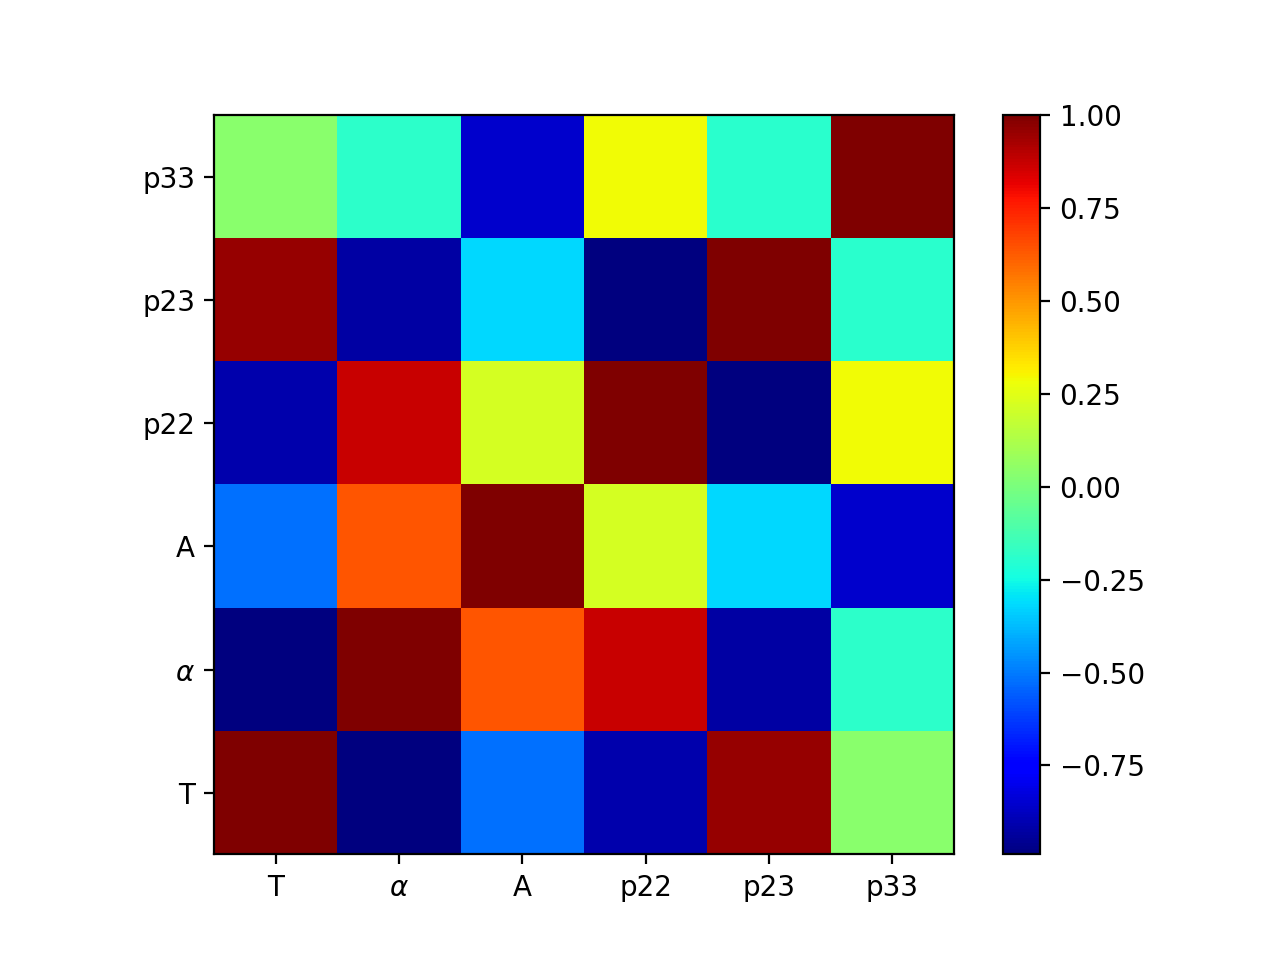

<IPython.core.display.Javascript object>


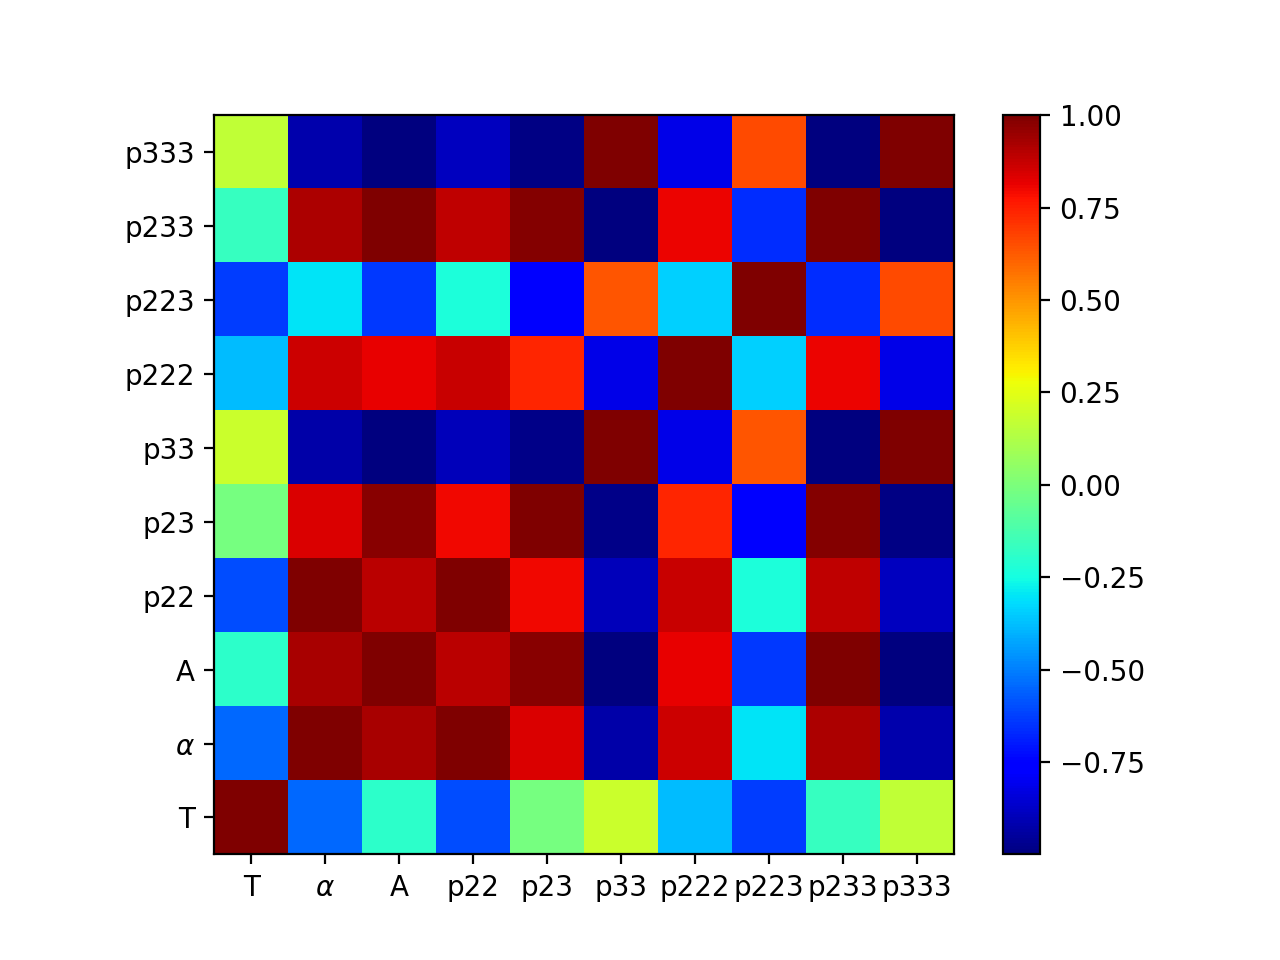

In [10]:
temp=zeros(fitcov1.shape,float)
for i in range(size(temp[:,0])):
    for j in range(size(temp[:,0])):
        temp[i,j]=fitcov1[i,j]/(sqrt(fitcov1[i,i])*sqrt(fitcov1[j,j]))

figure()
imshow(temp,origin="lower")
xticks([0,1,2,3,4,5],["T",r"$\alpha$","A","p22","p23","p33"])
yticks([0,1,2,3,4,5],["T",r"$\alpha$","A","p22","p23","p33"])
colorbar()
savefig(pathout + "6param_cov.pdf",dpi=150,bbox_inches="tight")
savefig(pathout + "6param_cov.jpeg",dpi=150,bbox_inches="tight")

temp=zeros(fitcov2.shape,float)
for i in range(size(temp[:,0])):
    for j in range(size(temp[:,0])):
        temp[i,j]=fitcov2[i,j]/(sqrt(fitcov2[i,i])*sqrt(fitcov2[j,j]))

        
figure()
imshow(temp,origin="lower")
xticks([0,1,2,3,4,5,6,7,8,9],["T",r"$\alpha$","A","p22","p23","p33","p222","p223","p233","p333"])
yticks([0,1,2,3,4,5,6,7,8,9],["T",r"$\alpha$","A","p22","p23","p33","p222","p223","p233","p333"])
colorbar()
savefig(pathout + "10param_cov.pdf",dpi=150,bbox_inches="tight")
savefig(pathout + "10param_cov.jpeg",dpi=150,bbox_inches="tight")

<IPython.core.display.Javascript object>


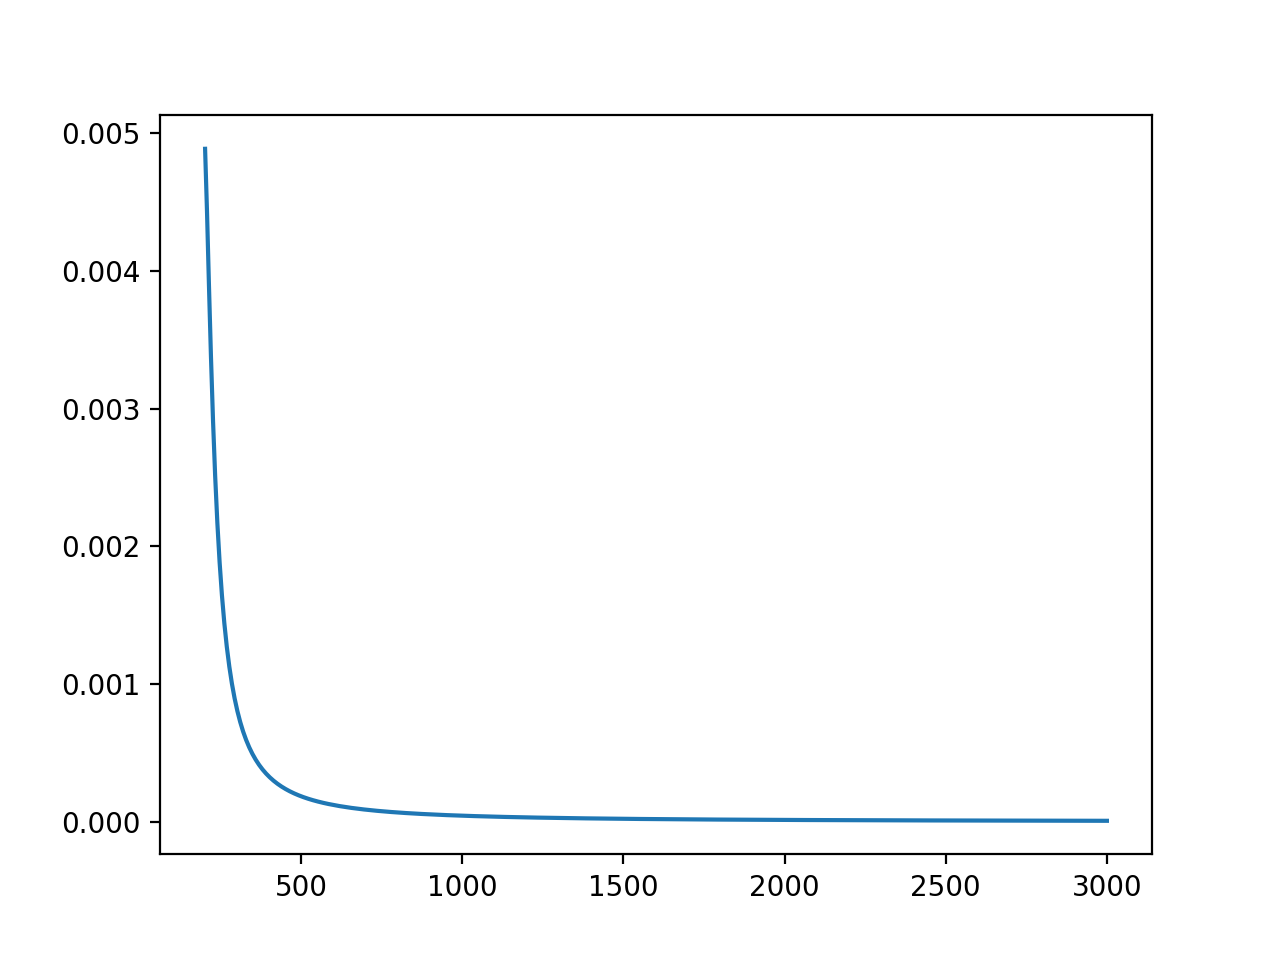

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app


In [78]:
figure()
plot(nu,1./(200+(nu-200)**1.5))